Generation 0: Best Distance = 783.87
Generation 50: Best Distance = 851.78
Generation 100: Best Distance = 754.62
Generation 150: Best Distance = 849.86
Generation 200: Best Distance = 860.90
Generation 250: Best Distance = 820.54
Generation 300: Best Distance = 841.85
Generation 350: Best Distance = 811.40
Generation 400: Best Distance = 897.16
Generation 450: Best Distance = 798.47


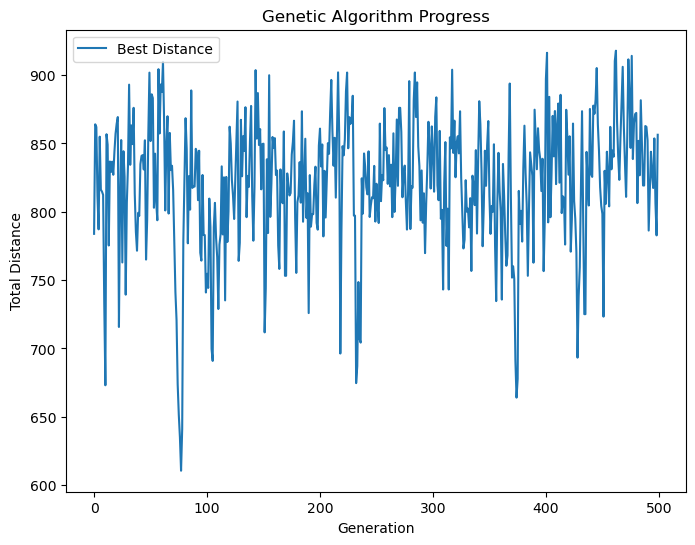

Best path: [1, 15, 18, 7, 3, 4, 9, 13, 6, 11, 17, 10, 16, 14, 19, 2, 0, 5, 8, 12]
Best Distance: 856.4007989707644


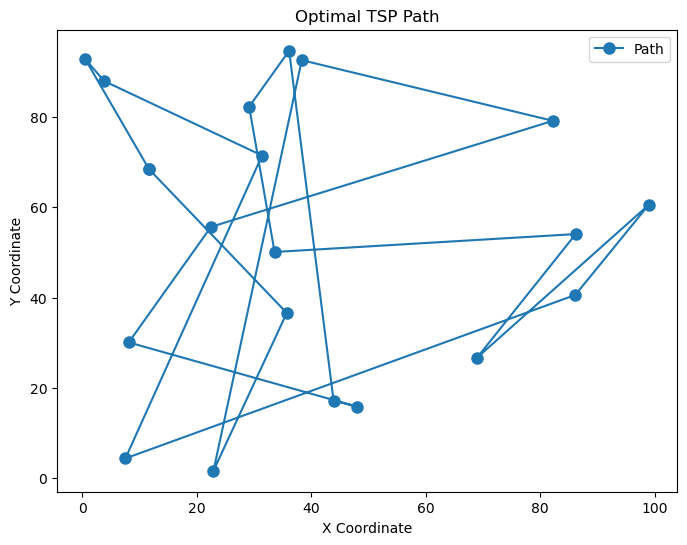

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

def distance(city1, city2):
    return np.linalg.norm(np.array(city1) - np.array(city2))

def total_distance(path, cities):
    return sum(distance(cities[path[i]], cities[path[i + 1]]) for i in range(-1, len(path) - 1))

class GeneticTSP:
    def __init__(self, cities, population_size=100, generations=500, mutation_rate=0.01):
        self.cities = cities
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.population = [random.sample(range(len(cities)), len(cities)) for _ in range(population_size)]
    
    def fitness(self, path):
        return 1 / total_distance(path, self.cities)
    
    def select_parents(self):
        fitness_scores = [self.fitness(path) for path in self.population]
        return random.choices(self.population, weights=fitness_scores, k=2)
    
    def crossover(self, parent1, parent2):
        size = len(parent1)
        start, end = sorted(random.sample(range(size), 2))
        child = [-1] * size
        child[start:end] = parent1[start:end]
        pos = end
        for gene in parent2:
            if gene not in child:
                if pos >= size:
                    pos = 0
                child[pos] = gene
                pos += 1
        return child
    
    def mutate(self, path):
        if random.random() < self.mutation_rate:
            i, j = random.sample(range(len(path)), 2)
            path[i], path[j] = path[j], path[i]
        return path
    
    def evolve(self):
        best_distances = []
        for generation in range(self.generations):
            new_population = []
            for _ in range(self.population_size // 2):
                parent1, parent2 = self.select_parents()
                child1, child2 = self.crossover(parent1, parent2), self.crossover(parent2, parent1)
                new_population.extend([self.mutate(child1), self.mutate(child2)])
            self.population = sorted(new_population, key=self.fitness, reverse=True)[:self.population_size]
            best_distances.append(total_distance(self.population[0], self.cities))
            if generation % 50 == 0:
                print(f"Generation {generation}: Best Distance = {best_distances[-1]:.2f}")
        self.plot_progress(best_distances)
        return min(self.population, key=lambda p: total_distance(p, self.cities))
    
    def plot_cities(self, path):
        ordered_cities = [self.cities[i] for i in path] + [self.cities[path[0]]]
        x, y = zip(*ordered_cities)
        plt.figure(figsize=(8, 6))
        plt.plot(x, y, 'o-', markersize=8, label="Path")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.title("Optimal TSP Path")
        plt.legend()
        plt.show()
    
    def plot_progress(self, distances):
        plt.figure(figsize=(8, 6))
        plt.plot(distances, label="Best Distance")
        plt.xlabel("Generation")
        plt.ylabel("Total Distance")
        plt.title("Genetic Algorithm Progress")
        plt.legend()
        plt.show()

if __name__ == "__main__":
    cities = [(random.uniform(0, 100), random.uniform(0, 100)) for _ in range(20)]
    ga_tsp = GeneticTSP(cities)
    best_path = ga_tsp.evolve()
    print("Best path:", best_path)
    print("Best Distance:", total_distance(best_path, cities))
    ga_tsp.plot_cities(best_path)
